In [1]:
import pytensor
import pymc as pm
import arviz as az

from scipy.stats import beta, hypergeom, gaussian_kde
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from scipy.optimize import minimize

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
with pm.Model():
    n, k = 10, 5
    theta = pm.Beta('theta', alpha = 1, beta = 1)
    obs = pm.Binomial('k', n = n, p = theta, observed = k)
    pm.sample(draws = 1000)

KeyboardInterrupt: 

In [3]:
with pm.Model():
    n_total, k_obs = 10, 5
    theta = pm.Beta('theta', alpha = 1, beta = 1)
    k = pm.Binomial('k', n = n_total, p = theta, observed = k_obs)
    trace_10_5 = pm.sample(draws = 1000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


In [3]:
with pm.Model() as model:
    N, s, M = 100, 35, 50
    s
    x = pm.HyperGeometric('x', N, s, M)
    z = pm.Deterministic('z', (1 + x)/(1 + M - x))

(array([1.000e+00, 9.000e+00, 1.500e+02, 8.710e+02, 2.334e+03, 3.221e+03,
        2.359e+03, 8.720e+02, 1.690e+02, 1.400e+01]),
 array([ 7.,  9., 11., 13., 15., 17., 19., 21., 23., 25., 27.]),
 <BarContainer object of 10 artists>)

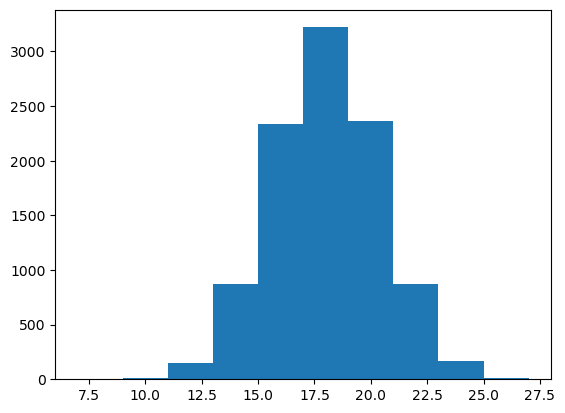

In [31]:
plt.hist(x)

In [116]:
ps = hypergeom.pmf(np.arange(M + 1), s, N-s, M)
ps

array([3.41896128e-11, 1.53853258e-08, 1.52314725e-06, 5.82180727e-05,
       1.06975709e-03, 1.05264097e-02, 5.84800541e-02, 1.86181397e-01,
       3.31635613e-01, 3.02975745e-01, 1.09071268e-01])

(0.0, 1.0)

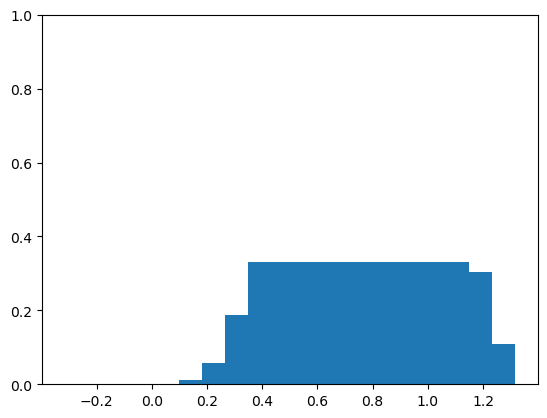

In [119]:
plt.bar(x = (np.arange(M + 1) + 1) / (M + 2), height = ps)
plt.ylim(0, 1)

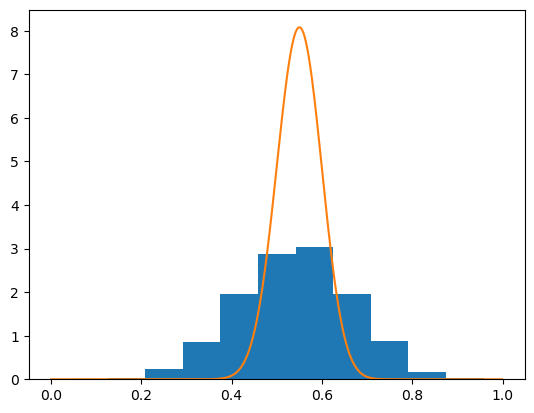

In [109]:
N, s, M = 100, 55, 10
x = np.random.hypergeometric(s, N-s, M, 10000)
thetahat = (x + 1) / (M + 2)
theta = np.arange(0, 1, 0.001)
# plt.plot(theta, gaussian_kde(thetahat)(theta))
plt.hist(thetahat, density=True, bins = np.arange(0.5/(M + 2), 1, 1/(M + 2)))
plt.plot(theta, beta.pdf(theta, s + 1, N - s + 1))



## 3.1 Inferring a rate

用图模型表示二项过程
- 圆形：连续变量;
- 矩形：离散变量;
- 空白：未知变量;
- 阴影：已知变量;

Notes: 
- pymc不鼓励出现已知常数(n);
- $Beta$ 分布是二项分布的共轭先验，$Beta(1,1)$ 代表 $Uniform(0,1)$;
- $Beta(\alpha, \beta)$ 代表 $\alpha$ 次正面和 $\beta$ 次反面的虚拟观测，可以和真实观测结合;
- 众数 $\frac{\alpha - 1}{\alpha + \beta - 2}$, 期望 $\frac{\alpha}{\alpha + \beta}$, 方差 $\frac{\alpha\beta}{(\alpha + \beta)^2(\alpha + \beta + 1)}$ 


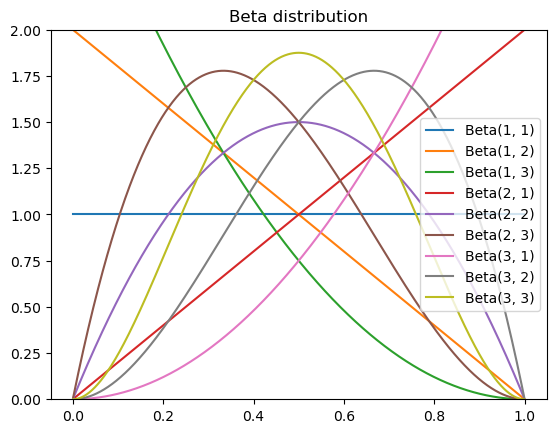

In [4]:
x_axis = np.arange(0.001, 1.000, 0.001)
for alpha_ in [1, 2, 3]:
    for beta_ in [1, 2, 3]:
        y_axis = beta.pdf(x_axis, alpha_, beta_)
        plt.plot(x_axis, y_axis, label = f'Beta({alpha_}, {beta_})')
plt.ylim(0, 2)
plt.title('Beta distribution')
plt.legend()

/Users/zhangxuyang/miniconda3/envs/pymc5/lib/python3.12/site-packages/pymc/data.py:235: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


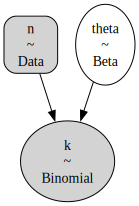

In [2]:
with pm.Model() as BinarayProcessModel:
    n_total, k_obs = 10, 5
    n = pm.ConstantData('n', n_total)
    theta = pm.Beta('theta', alpha = 1, beta = 1)
    k = pm.Binomial('k', n = n, p = theta, observed = k_obs)
pm.model_to_graphviz(BinarayProcessModel)

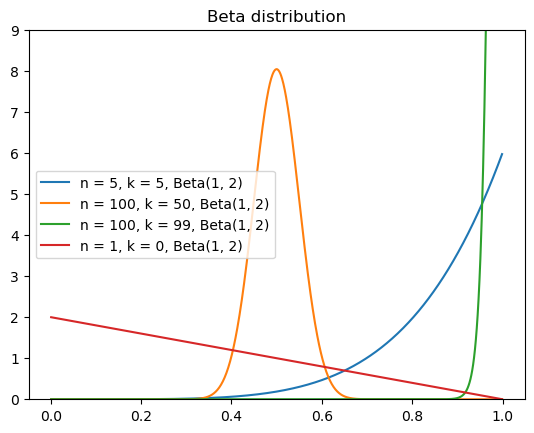

In [62]:
### Exercises1
x_axis = np.arange(0.001, 1.000, 0.001)
for (k, n) in [(5, 5), (50, 100), (99, 100), (0, 1)]:
    y_axis = beta.pdf(x_axis, k + 1, n - k + 1)
    plt.plot(x_axis, y_axis, label = f'n = {n}, k = {k}, Beta({alpha_}, {beta_})')
plt.ylim(0, 9)
plt.title('Beta distribution')
plt.legend()


In [4]:
# Exercise 3.1.1, 3.1.2
## n=10, k=5之后采样的结果和解析解是一致的
with pm.Model() as BinarayProcessModel:
    n_total, k_obs = 10, 5
    n = pm.ConstantData('n', n_total)
    theta = pm.Beta('theta', alpha = 1, beta = 1)
    k = pm.Binomial('k', n = n, p = theta, observed = k_obs)
    trace_10_5 = pm.sample(draws = 10000)
print('Sampling Results')
theta_posterior_samples = trace_10_5.posterior['theta'].values.flatten()
print(f'p(0.4<theta<0.6 = {(abs(theta_posterior_samples - 0.5) < 0.1).sum()/len(theta_posterior_samples):.3f})')
kde = gaussian_kde(theta_posterior_samples)
print(f'p(0.5|n, k)/p(0.7|n,k) = {(kde(0.5)/kde(0.7)).item():.3f}')
print('Analytic Results')
print(f'p(0.4<theta<0.6 = {beta.cdf(0.6, 6, 6) - beta.cdf(0.4, 6, 6):.3f})')
print(f'p(0.5|n, k)/p(0.7|n,k) = {beta.pdf(0.5, 6, 6) / beta.pdf(0.7, 6, 6):.3f}')

/Users/zhangxuyang/miniconda3/envs/pymc5/lib/python3.12/site-packages/pymc/data.py:235: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 22 seconds.


Sampling Results
p(0.4<theta<0.6 = 0.508)
p(0.5|n, k)/p(0.7|n,k) = 2.317
Analytic Results
p(0.4<theta<0.6 = 0.507)
p(0.5|n, k)/p(0.7|n,k) = 2.391


In [3]:
# Exercise 3.1.3
## 改成n=100，k=50，发现sampling对概率极端小的地方sample并不准确
with pm.Model() as BinarayProcessModel:
    n_total, k_obs = 100, 50
    n = pm.ConstantData('n', n_total)
    theta = pm.Beta('theta', alpha = 1, beta = 1)
    k = pm.Binomial('k', n = n, p = theta, observed = k_obs)
    trace_100_50 = pm.sample(draws = 1000)

print('Sampling Results')
theta_posterior_samples = trace_100_50.posterior['theta'].values.flatten()
print(f'p(0.4<theta<0.6 = {(abs(theta_posterior_samples - 0.5) < 0.1).sum()/len(theta_posterior_samples):.3f})')
kde = gaussian_kde(theta_posterior_samples)
print(f'p(0.5|n, k)/p(0.7|n,k) = {(kde(0.5)/kde(0.7)).item():.3f}')
print('Analytic Results')
print(f'p(0.4<theta<0.6 = {beta.cdf(0.6, 51, 51) - beta.cdf(0.4, 51, 51):.3f})')
print(f'p(0.5|n, k)/p(0.7|n,k) = {beta.pdf(0.5, 51, 51) / beta.pdf(0.7, 51, 51):.3f}')

/Users/zhangxuyang/miniconda3/envs/pymc5/lib/python3.12/site-packages/pymc/data.py:235: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


In [89]:
# Exercise 3.1.4
## 采样减少十倍（draws=1000是默认值，结果是不太接近的）
with pm.Model() as BinarayProcessModel:
    n_total, k_obs = 10, 5
    n = pm.ConstantData('n', n_total)
    theta = pm.Beta('theta', alpha = 1, beta = 1)
    k = pm.Binomial('k', n = n, p = theta, observed = k_obs)
    trace_10_5_d1000 = pm.sample(draws = 1000)
print('Sampling Results')
theta_posterior_samples = trace_10_5_d1000.posterior['theta'].values.flatten()
print(f'p(0.4<theta<0.6 = {(abs(theta_posterior_samples - 0.5) < 0.1).sum()/len(theta_posterior_samples):.3f})')
kde = gaussian_kde(theta_posterior_samples)
print(f'p(0.5|n, k)/p(0.7|n,k) = {(kde(0.5)/kde(0.7)).item():.3f}')
print('Analytic Results')
print(f'p(0.4<theta<0.6 = {beta.cdf(0.6, 6, 6) - beta.cdf(0.4, 6, 6):.3f})')
print(f'p(0.5|n, k)/p(0.7|n,k) = {beta.pdf(0.5, 6, 6) / beta.pdf(0.7, 6, 6):.3f}')

/Users/zhangxuyang/miniconda3/envs/pymc5/lib/python3.12/site-packages/pymc/data.py:235: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


Sampling Results
p(0.4<theta<0.6 = 0.502)
p(0.5|n, k)/p(0.7|n,k) = 2.291
Analytic Results
p(0.4<theta<0.6 = 0.507)
p(0.5|n, k)/p(0.7|n,k) = 2.391


/Users/zhangxuyang/miniconda3/envs/pymc5/lib/python3.12/site-packages/pymc/data.py:235: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 24 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.98,0.014,0.955,0.999,0.0,0.0,2373.0,2749.0,1.0


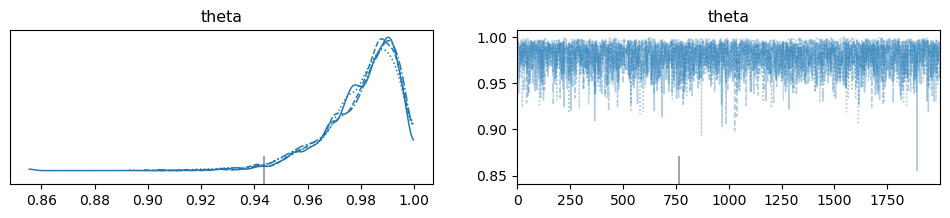

In [95]:
# Exercise 3.1.5
## n = 100, k = 99
with pm.Model() as BinarayProcessModel:
    n_total, k_obs = 100, 99
    n = pm.ConstantData('n', n_total)
    theta = pm.Beta('theta', alpha = 1, beta = 1)
    k = pm.Binomial('k', n = n, p = theta, observed = k_obs)
    trace_100_99 = pm.sample(draws = 2000)
az.plot_trace(trace_100_99, var_names=['theta'])
az.summary(trace_100_99, var_names=['theta'])

/Users/zhangxuyang/miniconda3/envs/pymc5/lib/python3.12/site-packages/pymc/data.py:235: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 23 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.326,0.236,0.0,0.753,0.004,0.002,3020.0,3125.0,1.0


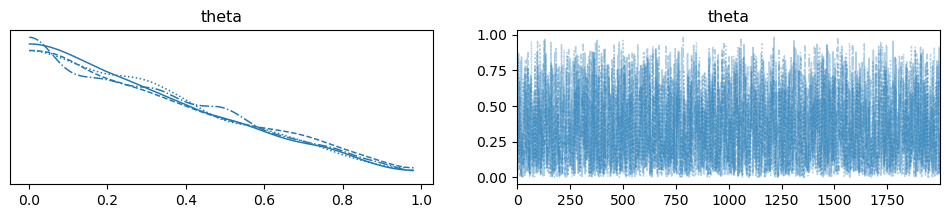

In [96]:
# Exercise 3.1.6
## n = 1, k = 0
with pm.Model() as BinarayProcessModel:
    n_total, k_obs = 1, 0
    n = pm.ConstantData('n', n_total)
    theta = pm.Beta('theta', alpha = 1, beta = 1)
    k = pm.Binomial('k', n = n, p = theta, observed = k_obs)
    trace_1_0 = pm.sample(draws = 2000)
az.plot_trace(trace_1_0, var_names=['theta'])
az.summary(trace_1_0, var_names=['theta'])

## 3.2 Difference between two rates

对于后验分布，需要关心的统计量点估计：
- 后验期望，sample的均值，对应平方损失函数
- 后验最大（MAP，maximum a posterior），sampling核密度估计的结果，对应01损失函数
- 后验中位数，sample的中位数，对应线形损失函数
- 置信区间（为什么叫HDI呢），就是sample的分位数

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 26 seconds.


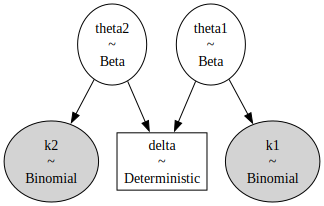

In [103]:
with pm.Model() as DifferenceModel:
    n1, n2 = 10, 10
    k1_obs, k2_obs = 5, 7
    theta1 = pm.Beta('theta1', alpha = 1, beta = 1)
    theta2 = pm.Beta('theta2', alpha = 1, beta = 1)
    k1 = pm.Binomial('k1', n = n1, p = theta1, observed = k1_obs)
    k2 = pm.Binomial('k2', n = n2, p = theta2, observed = k2_obs)
    delta = pm.Deterministic('delta', theta2 - theta1)
    trace_diff = pm.sample(draws = 10000)
pm.model_to_graphviz(DifferenceModel)



,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta1,0.500,0.140,0.242,0.758,0.001,0.001,39215.0,28382.0,1.0
theta2,0.668,0.131,0.426,0.902,0.001,0.001,39753.0,27507.0,1.0
delta,0.168,0.191,-0.199,0.515,0.001,0.001,40073.0,30299.0,1.0


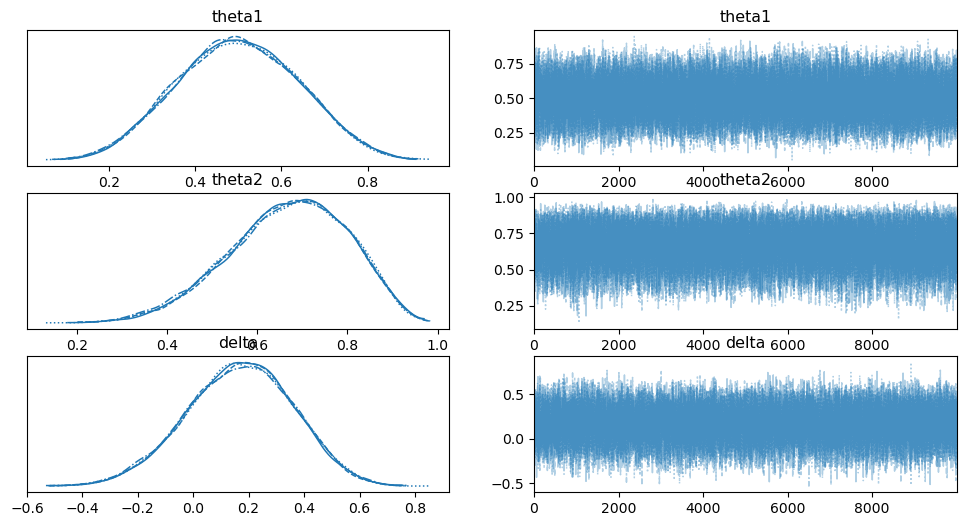

In [104]:
az.plot_trace(trace_diff)
az.summary(trace_diff, var_names=['theta1', 'theta2', 'delta'])

In [119]:
delta = trace_diff.posterior['delta'].values.flatten()
delta.mean(), np.median(delta)
x_range = np.arange(-0.5, 0.5, 0.001)
idx = np.argmax(gaussian_kde(delta)(x_range))
delta.mean(), np.median(delta), x_range[idx]

(0.16812563949758624, 0.17306528486263248, 0.15600000000000058)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 26 seconds.


array([[<Axes: title={'center': 'theta1'}>,
        <Axes: title={'center': 'theta1'}>],
       [<Axes: title={'center': 'theta2'}>,
        <Axes: title={'center': 'theta2'}>],
       [<Axes: title={'center': 'delta'}>,
        <Axes: title={'center': 'delta'}>]], dtype=object)

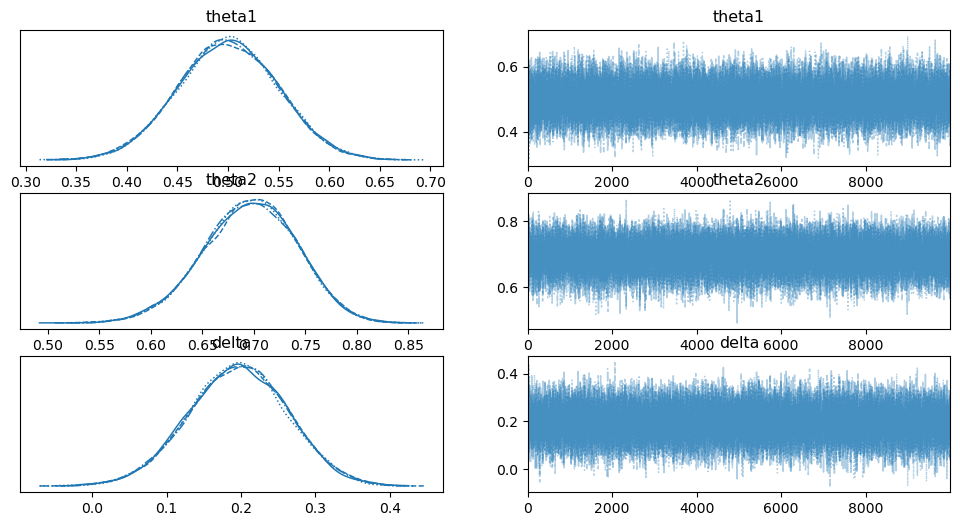

In [120]:
# Exercise3.2.1
## 这里我们就用(100, 50), (100, 70)和正文例子做对比
## 很明显相同的比例更多的观测更容易得到效果
with pm.Model() as DifferenceModel:
    n1, n2 = 100, 100
    k1_obs, k2_obs = 50, 70
    theta1 = pm.Beta('theta1', alpha = 1, beta = 1)
    theta2 = pm.Beta('theta2', alpha = 1, beta = 1)
    k1 = pm.Binomial('k1', n = n1, p = theta1, observed = k1_obs)
    k2 = pm.Binomial('k2', n = n2, p = theta2, observed = k2_obs)
    delta = pm.Deterministic('delta', theta2 - theta1)
    trace_diff_more = pm.sample(draws = 10000)
az.plot_trace(trace_diff_more)
az.summary(trace_diff_more)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 28 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta1,0.332,0.235,0.000,0.754,0.001,0.001,30127.0,19777.0,1.0
theta2,0.142,0.123,0.000,0.373,0.001,0.001,25901.0,18945.0,1.0
delta,-0.191,0.265,-0.738,0.251,0.001,0.001,31723.0,25366.0,1.0


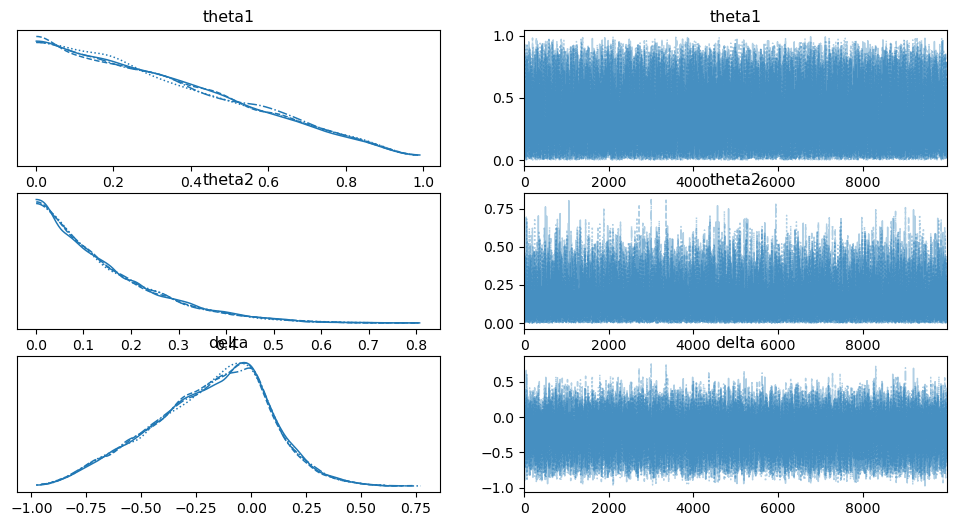

In [122]:
# Exercise3.2.2
## 这里我们对比(1, 0), (5, 0)和正文例子做对比
## 更多失败的观测后，后验更接近似然而非先验
with pm.Model() as DifferenceModel:
    n1, n2 = 1, 5
    k1_obs, k2_obs = 0, 0
    theta1 = pm.Beta('theta1', alpha = 1, beta = 1)
    theta2 = pm.Beta('theta2', alpha = 1, beta = 1)
    k1 = pm.Binomial('k1', n = n1, p = theta1, observed = k1_obs)
    k2 = pm.Binomial('k2', n = n2, p = theta2, observed = k2_obs)
    delta = pm.Deterministic('delta', theta2 - theta1)
    trace_diff_zero = pm.sample(draws = 10000)
az.plot_trace(trace_diff_zero)
az.summary(trace_diff_zero)


## 3.3 Inferring a common rate

- plate notation: 一种类似for循环的存在

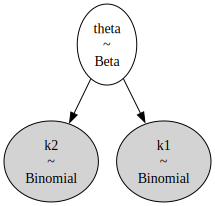

In [123]:
with pm.Model() as CommonRateModel:
    n1, n2, obs1, obs2 = 10, 15, 7, 8
    theta = pm.Beta('theta', alpha = 1, beta = 1)
    k1 = pm.Binomial('k1', n = n1, p = theta, observed = obs1)
    k2 = pm.Binomial('k2', n = n2, p = theta, observed = obs2)
pm.model_to_graphviz(CommonRateModel)

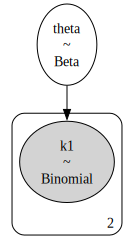

In [124]:
with pm.Model() as CommonRateModelCompact:
    n, obs = [10, 15], [7, 8]
    theta = pm.Beta('theta', alpha = 1, beta = 1)
    k = pm.Binomial('k1', n = n, p = theta, observed = obs)
pm.model_to_graphviz(CommonRateModelCompact)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 34 seconds.


array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

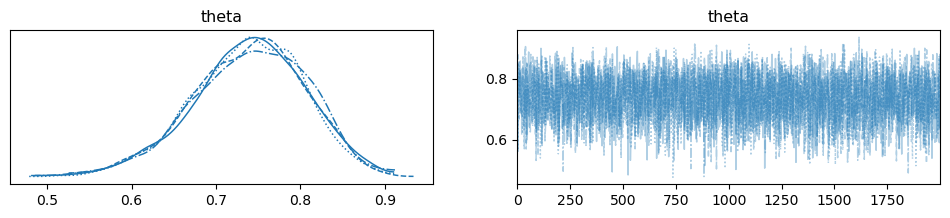

In [126]:
with pm.Model() as CommonRateModel:
    n, obs = [20, 20], [14, 16]
    theta = pm.Beta('theta', alpha = 1, beta = 1)
    k = pm.Binomial('k1', n = n, p = theta, observed = obs)
    trace_ex331 = pm.sample(draws = 2000)
az.plot_trace(trace_ex331)
az.summary(trace_ex331)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 32 seconds.


array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

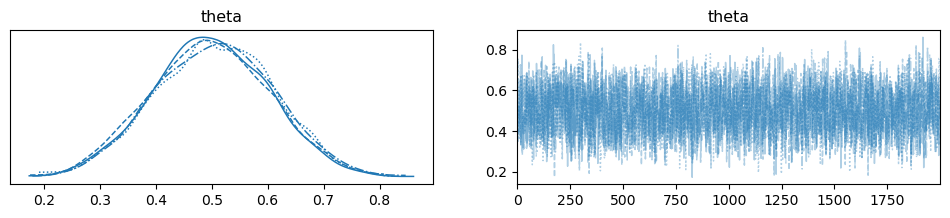

In [127]:
# Exercise 3.3.2
## Bayesian推断的结果不一定可靠，因为模型假设common rate可能是不对的
with pm.Model() as CommonRateModel:
    n, obs = [10, 10], [0, 10]
    theta = pm.Beta('theta', alpha = 1, beta = 1)
    k = pm.Binomial('k1', n = n, p = theta, observed = obs)
    trace_ex332 = pm.sample(draws = 2000)
az.plot_trace(trace_ex332)
az.summary(trace_ex332)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 21 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.502,0.105,0.313,0.702,0.002,0.001,3525.0,5797.0,1.0


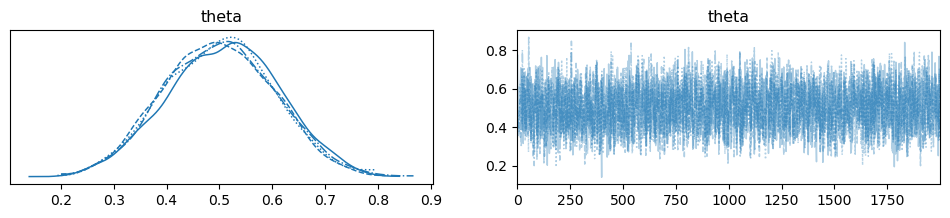

In [129]:
# Exercise 3.3.3
## 和3.3.2的结果和到一起是完全一样的，贝叶斯推断没有记忆
with pm.Model() as CommonRateModel:
    n, obs = [10, 10], [3, 7]
    theta = pm.Beta('theta', alpha = 1, beta = 1)
    k = pm.Binomial('k1', n = n, p = theta, observed = obs)
    trace_ex333 = pm.sample(draws = 2000)
az.plot_trace(trace_ex333)
az.summary(trace_ex333)

In [133]:
az.summary(trace_ex332), az.summary(trace_ex333)

(        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
 theta  0.502  0.105   0.304    0.695      0.002    0.001    3238.0    5756.0   
 
        r_hat  
 theta    1.0  ,
         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
 theta  0.502  0.105   0.313    0.702      0.002    0.001    3525.0    5797.0   
 
        r_hat  
 theta    1.0  )

## 3.4 Prior and Posterior Prediction

贝叶斯推断中四个重要的概率分布：
- 先验分布和后验分布（关于参数的）
- 先验预测分布和后验预测分布（关于数据的）


In [140]:
with pm.Model() as BinarayProcessModel:
    n, k_obs = 10, 5
    theta = pm.Beta('theta', alpha = 1, beta = 1)
    k = pm.Binomial('k', n = n, p = theta, observed = k_obs)
    prior_pred = pm.sample_prior_predictive(samples = 10000)
    trace = pm.sample(draws = 10000)
    post_pred = pm.sample_posterior_predictive(trace, var_names=['k'])

Sampling: [k, theta]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 23 seconds.
Sampling: [k]


Output()

<Axes: >

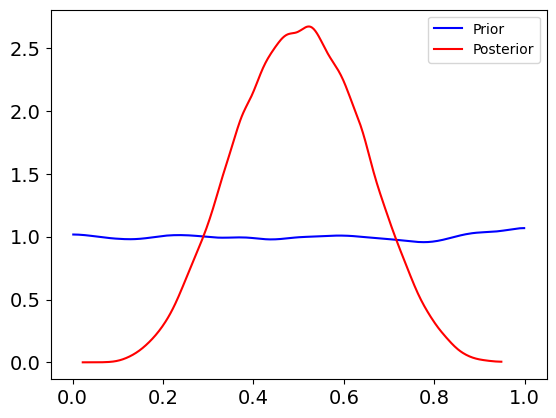

In [143]:
az.plot_dist(prior_pred.prior['theta'], label = 'Prior', color = 'blue')
az.plot_dist(trace.posterior['theta'], label = 'Posterior', color = 'red')

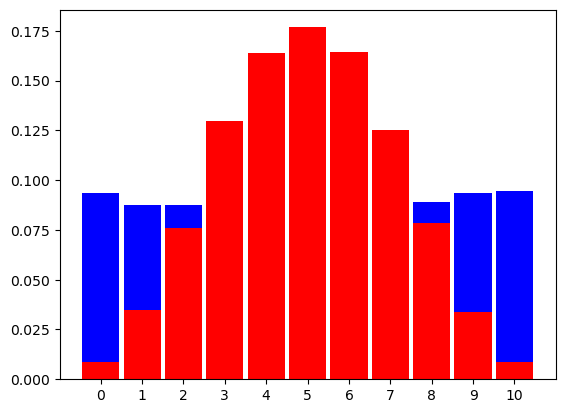

In [160]:
az.plot_dist(prior_pred.prior_predictive['k'], color = 'blue', fill_kwargs={"alpha": 0.1})
az.plot_dist(post_pred.posterior_predictive['k'], color = 'red', fill_kwargs={"alpha": 0.1})
plt.show()

In [169]:
# Exercise 3.4.3和3.4.4
n_old, k, n_new = 121, 24, 500
with pm.Model() as Bullying:
    theta = pm.Beta("theta", alpha = 1, beta = 1)
    obs = pm.Binomial("obs", n = n_old, p = theta, observed = k)
    prd = pm.Binomial("prd", n = n_new, p = theta)
    trace = pm.sample(10000)
    post_pred = pm.sample_posterior_predictive(trace, var_names=["prd"])


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [theta]
>Metropolis: [prd]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 27 seconds.
Sampling: [prd]


Output()

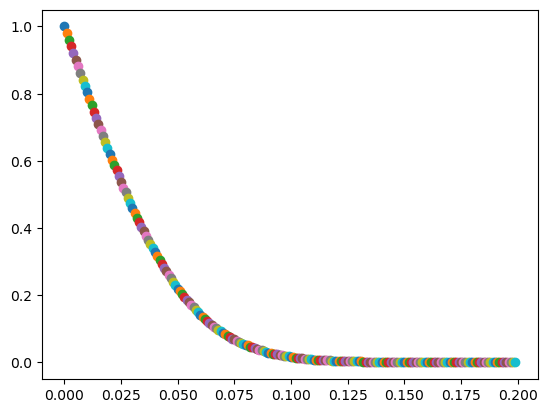

In [195]:
# 后验预测分布（如果你采购了500人），和目前算出来的比例还是差非常多的
## 很像bootstrap左脚踩右脚的螺旋上天
# az.plot_ecdf(post_pred.posterior_predictive['prd'])
az.summary(post_pred.posterior_predictive['prd'])
ratio = post_pred.posterior_predictive['prd'].values/500
for x in np.arange(0, 0.2, 0.001):
    plt.scatter(x, (abs(ratio - 24/121) > x).mean())


## 3.5 Posterior Prediction

后验预测分布可以检验模型的有效性
- 本身就是关于模型预期能看到怎样数据的预测
- 如果预测和数据不match，模型就是有问题的

推断的基本问题
- 使用过去的数据预测未来的数据

Notes: 
- $\theta$ 的后验分布是一维的，而 $k$ 的后验预测分布是二维的
- 后验预测分布可以看作是模型证据，本例子中表明数据不像是从当前模型中产生出来的



Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 27 seconds.
Sampling: [k1, k2]


Output()

<Axes: xlabel='k1', ylabel='k2'>

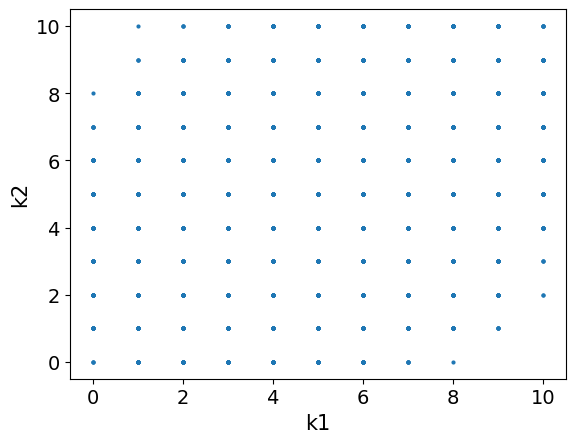

In [215]:
with pm.Model() as CommonRateModel:
    n1, n2, obs1, obs2 = 10, 10, 0, 10
    theta = pm.Beta('theta', alpha = 1, beta = 1)
    k1 = pm.Binomial('k1', n = n1, p = theta, observed = obs1)
    k2 = pm.Binomial('k2', n = n2, p = theta, observed = obs2)
    trace = pm.sample(10000)
    post_pred = pm.sample_posterior_predictive(trace, var_names=['k1', 'k2'])

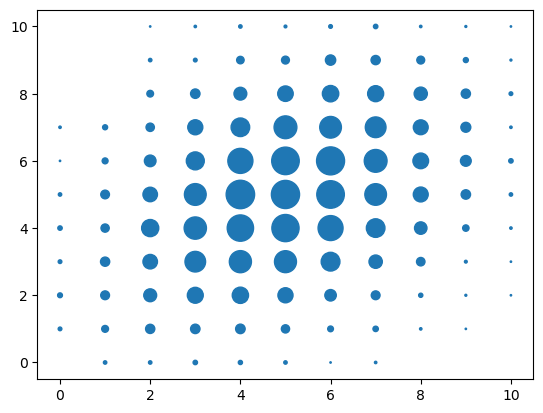

In [226]:
k1 = post_pred.posterior_predictive['k1'].values[0]
k2 = post_pred.posterior_predictive['k2'].values[0]
pairs, counts = np.unique(np.array([k1, k2]).T, axis=0, return_counts=True)
plt.scatter(pairs[:, 0], pairs[:, 1], s = counts)

## 3.6 Joint distributions

现实研究中往往有不止一个变量需要我们去关心
- 绘制联合分布：可以看到边缘分布所看不到的东西（例如两个变量之间的相关）

Notes:
- 后验期望甚至不在样本中，这是可能出现的，就像圆环的中心在圆心一样
- 后验众数看上去比较好，但是是个不稳定的结果



In [297]:
with pm.Model() as Survey:
    k_obs = [16, 18, 22, 25, 27]
    theta = pm.Beta('theta', alpha = 1, beta = 1)
    n = pm.DiscreteUniform('n', lower = 1, upper = 500)
    k = pm.Binomial('k', n = n, p = theta, observed = k_obs)
    trace = pm.sample(draws = 10000)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [theta]
>Metropolis: [n]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 26 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: >, None],
       [<Axes: xlabel='n', ylabel='theta'>, <Axes: >]], dtype=object)

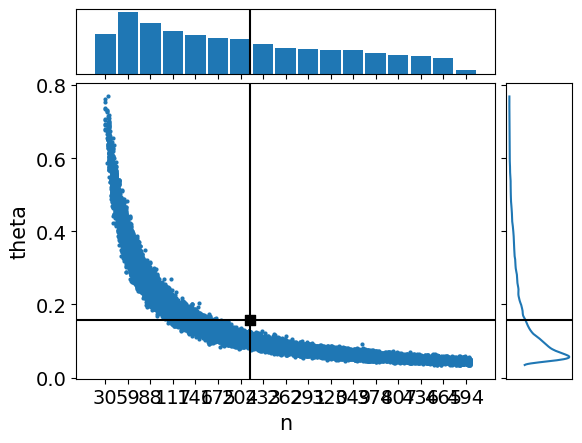

In [281]:
az.plot_pair(trace, var_names=['n', 'theta'], marginals = True, point_estimate='mean')

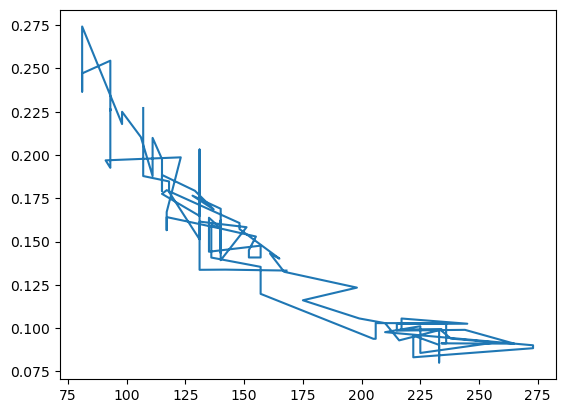

In [298]:
# Exercise 3.6.4 Atuocorr
## 两个变量有比较强的正相关
theta = trace.posterior['theta'].values[0]
n = trace.posterior['n'].values[0]
plt.plot(n[:100], theta[:100])

In [299]:
# Exercise 3.6.2
## mode在pymc的函数中不常见，可见他不是一个很好的东西
def binary_mode(var1, var2):
    samples = np.vstack([var1, var2])
    kde = gaussian_kde(samples)
    x_grid = np.linspace(min(var1), max(var1), 100)
    y_grid = np.linspace(min(var2), max(var2), 100)
    grid_x, grid_y = np.meshgrid(x_grid, y_grid)
    grid = np.vstack((grid_x.ravel(), grid_y.ravel())).T
    result = [kde(g) for g in grid]
    idx = np.argmax(result)
    return grid[idx]

mode = binary_mode(n, theta)
print(f'Mode: n = {mode[0]:.0f}, theta = {mode[1]:.3f}')
print(f'Mean: n = {n.mean():.0f}, theta = {theta.mean():.3f}')

Mode: n = 141, theta = 0.159
Mean: n = 219, theta = 0.184


In [300]:
# Exercise 3.6.3
## Mode是一个不稳定的结果嘛？这里改了最小值和最大值似乎mode还算稳定
with pm.Model() as Survey:
    k_obs = [15, 18, 22, 25, 28]
    theta = pm.Beta('theta', alpha = 1, beta = 1)
    n = pm.DiscreteUniform('n', lower = 1, upper = 500)
    k = pm.Binomial('k', n = n, p = theta, observed = k_obs)
    trace = pm.sample(draws = 10000)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [theta]
>Metropolis: [n]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 25 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [301]:
theta = trace.posterior['theta'].values[0]
n = trace.posterior['n'].values[0]
mode = binary_mode(n, theta)
print(f'Mode: n = {mode[0]:.0f}, theta = {mode[1]:.3f}')
print(f'Mean: n = {n.mean():.0f}, theta = {theta.mean():.3f}')

Mode: n = 139, theta = 0.158
Mean: n = 196, theta = 0.167
